# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras , os , tqdm , cv2
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , BatchNormalization , Dropout , Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load Data

In [2]:
trainDir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
testDir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [3]:
def loadTrsinData (trainDir , imageWidth , imageHight) :
  classes = os.listdir(trainDir)
  imagesList = []
  labels = []
  for clas in tqdm.tqdm(classes) :
    classesPath = os.path.join(trainDir,clas)
    for image in os.listdir(classesPath) :
      imgPath = os.path.join(trainDir,clas,image)
      img = cv2.imread(imgPath)
      img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img , (imageWidth , imageHight))
      imagesList.append(img)
      labels.append(clas)

  return imagesList , labels


# Explore Data

In [4]:
def displaySampleOfData (trainDir , imageWidth , imageHight) :
  plt.figure(figsize=(10,15))
  classes = os.listdir(trainDir)
  for i,clas in tqdm.tqdm(enumerate(classes)):
    plt.subplot(6,5,i+1)
    classesPath = os.path.join(trainDir,clas)
    image = os.listdir(classesPath)[0]
    image = os.path.join(trainDir,clas,image)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img , (imageWidth , imageHight))
    plt.title(clas)
    plt.imshow(img , cmap='gray')
  plt.show()


In [5]:
displaySampleOfData(trainDir ,60 ,60 )

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

<Figure size 1000x1500 with 0 Axes>

In [ ]:
# load data after explore the images and study it's case
X , y = loadTrsinData(trainDir , 60 , 60)

100%|██████████| 29/29 [10:42<00:00, 22.14s/it]


In [ ]:
testImages = []
testLabels = []
for img in tqdm.tqdm(os.listdir(testDir)):
  trainImagePath = os.path.join(testDir , img)
  image = cv2.imread(trainImagePath)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(60,60))
  testImages.append(image)
  testLabels.append(img)

100%|██████████| 28/28 [00:00<00:00, 204.55it/s]


# Data preprocessing

## train

In [ ]:
# shuffles x and y to make better training
XShuffled , yShuffled = shuffle(X,y,random_state=42)

In [ ]:
# convert list to np array
xtrain = np.array(XShuffled)
ytrain = np.array(yShuffled)

In [ ]:
# shape of xtrain
xtrain.shape

(87000, 60, 60)

In [ ]:
# Scale the train data
xtrain = xtrain.astype('float32') / 255.0

In [ ]:
# Reshape xtrain to fit conv network
xtrainReshaped = xtrain.reshape( (87000, 60, 60 , 1) )

In [ ]:
xtrainReshaped.shape

(87000, 60, 60, 1)

In [ ]:
# Create list of classes and dic to convert y labels to numbers
cats = [i for i in os.listdir(trainDir)]
categories = {}
for i,c in enumerate(cats) :
  categories[c] = i

In [ ]:
# convert labels in ytrain to numbers
for i in range (len(ytrain)) :
  ytrain[i] = categories[ytrain[i]]

ytrain

array(['19', '9', '11', ..., '25', '0', '5'], dtype='<U7')

In [ ]:
# Convert ytrain from numpy array to categoricl formate to fit in the training
ytrain = to_categorical(ytrain)

## test

In [ ]:
testImages = np.array(testImages)
testLabels = np.array(testLabels)

In [ ]:
testImages = testImages.astype('float32') / 255.0

In [ ]:
testImages = testImages.reshape( (-1, 60, 60 , 1) )

In [ ]:
for i in range(len(testLabels)) :
  testLabels[i] = testLabels[i].split('_')[0]

testLabels

array(['A', 'E', 'L', 'N', 'S', 'D', 'G', 'I', 'W', 'M', 'nothing', 'X',
       'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'U', 'space', 'O', 'B', 'R',
       'F', 'Z', 'J', 'K'], dtype='<U16')

In [ ]:
testDic = {}
for i,c in enumerate(testLabels):
  testDic[c]=i

In [ ]:
for i in range( len(testLabels) ):
  testLabels[i] = testDic[testLabels[i]]

In [ ]:
testLabels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27'], dtype='<U16')

In [ ]:
testLabels = to_categorical(testLabels , num_classes=29)

In [ ]:
testImages = np.array(testImages, dtype=np.float32)
testLabels = np.array(testLabels, dtype=np.int32)

# Data Modeling

In [ ]:
Model = Sequential ([
    Conv2D(128 , (3,3) , activation='relu' , input_shape =(60,60,1)),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256 , activation='relu'),
    Dropout(0.2),
    Dense(128 , activation='relu'),
    Dropout(0.15),
    Dense(64 , activation='relu'),
    Dense(len(cats) , activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746825795.176039      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746825795.176727      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
Model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
Model.fit(xtrainReshaped , ytrain  , validation_split=0.2 , epochs = 10)

Epoch 1/10


I0000 00:00:1746825802.410203      64 service.cc:148] XLA service 0x7bfba00026d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746825802.411086      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746825802.411104      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746825802.796188      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  21/2175 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.0294 - loss: 3.3728

I0000 00:00:1746825806.635598      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.2878 - loss: 2.3850 - val_accuracy: 0.8520 - val_loss: 0.4353
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8204 - loss: 0.5157 - val_accuracy: 0.9334 - val_loss: 0.1982
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9013 - loss: 0.2886 - val_accuracy: 0.9690 - val_loss: 0.0956
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9267 - loss: 0.2148 - val_accuracy: 0.9801 - val_loss: 0.0648
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9435 - loss: 0.1689 - val_accuracy: 0.9806 - val_loss: 0.0592
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9544 - loss: 0.1385 - val_accuracy: 0.9731 - val_loss: 0.0799
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9609 - loss: 0.1243 - val_accuracy: 0.9749 - val_loss: 0.0754
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9674 - loss: 0.0995 - val

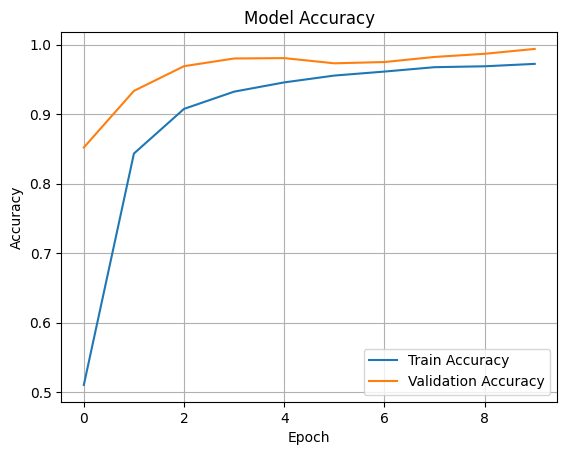

In [ ]:
plt.plot(Model.history.history['accuracy'], label='Train Accuracy')
plt.plot(Model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()